## First attempt
This is my first attempt, using a very simple approach. I run all the training data through a cross-validated multinomial boosted tree model, and choose the model which obtains the minimum cross-validation loss.

[This is me](https://www.linkedin.com/in/%C3%B8ystein-s%C3%B8rensen-4a877831/)

## Data load

In [3]:
trainingData <- read.csv("../training_data.csv")
testData <- read.csv("../validation_data_nofacies.csv")

# Convert the class labels to factor
trainingData$Facies <- as.factor(trainingData$Facies)

## Multinomial boosted tree model

In [7]:
library(gbm) # Using the gbm package

# Training the model using 10-fold cross validation
fit <- gbm(Facies ~ Formation + Well.Name + Depth + GR + ILD_log10 + DeltaPHI + PHIND + PE + NM_M + RELPOS,
           distribution = "multinomial",
           n.trees = 15000,
           interaction.depth = 8,
           cv.folds = 10,
           data = trainingData, 
          n.cores = 7)

## Inspect the performance

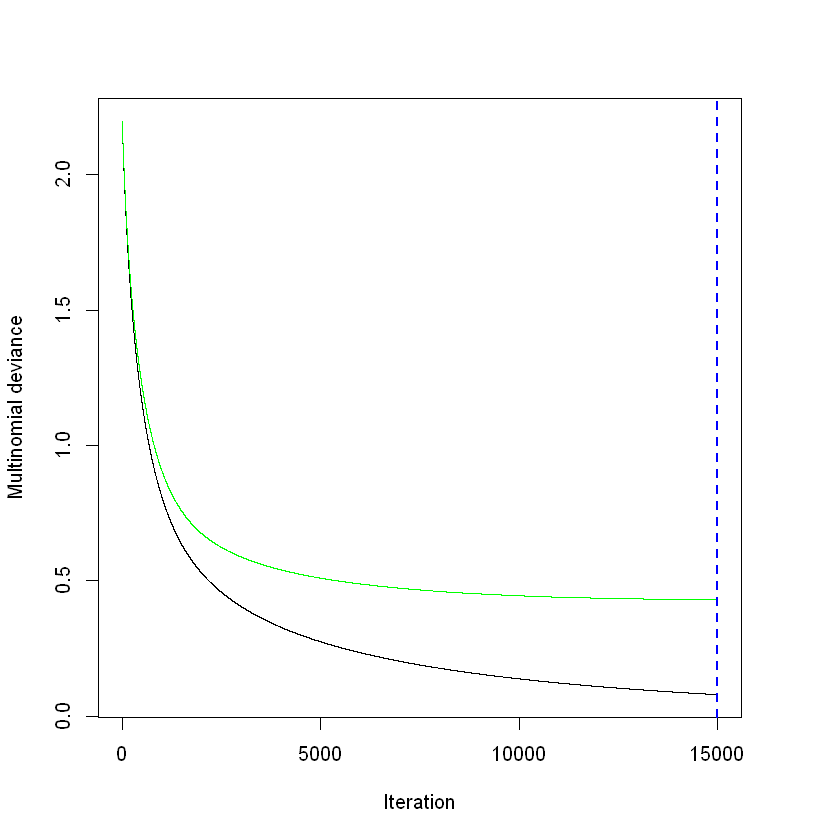

In [11]:
optNumTrees <- gbm.perf(fit, method = "cv")

We have not yet reached cross-validated optimum on test data (green curve), but we seem to be close.

## Prediction

In [37]:
# Compute the link function
estimatedLink <- predict(fit, newdata = testData, type = "link", n.trees = optNumTrees)[,,1]
# Use the classification with highest probability
prediction <- apply(estimatedLink, 1, which.max)
# Add this as a new column to testData
submission <- cbind(testData, Facies = prediction)

In [40]:
# Write to csv
write.csv(submission, file = "./prediction.csv")